In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
import csv
import pywt


In [2]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]

# tmp_real=sum(raw_data_channel_0.real)/len(raw_data_channel_0)
# tmp_img= sum(raw_data_channel_0.imag)/len(raw_data_channel_0)
# raw_data_channel_0=raw_data_channel_0-complex(tmp_real,tmp_img)

![Screen Shot 2023-08-25 at 10.26.19 AM.png](<attachment:Screen Shot 2023-08-25 at 10.26.19 AM.png>)
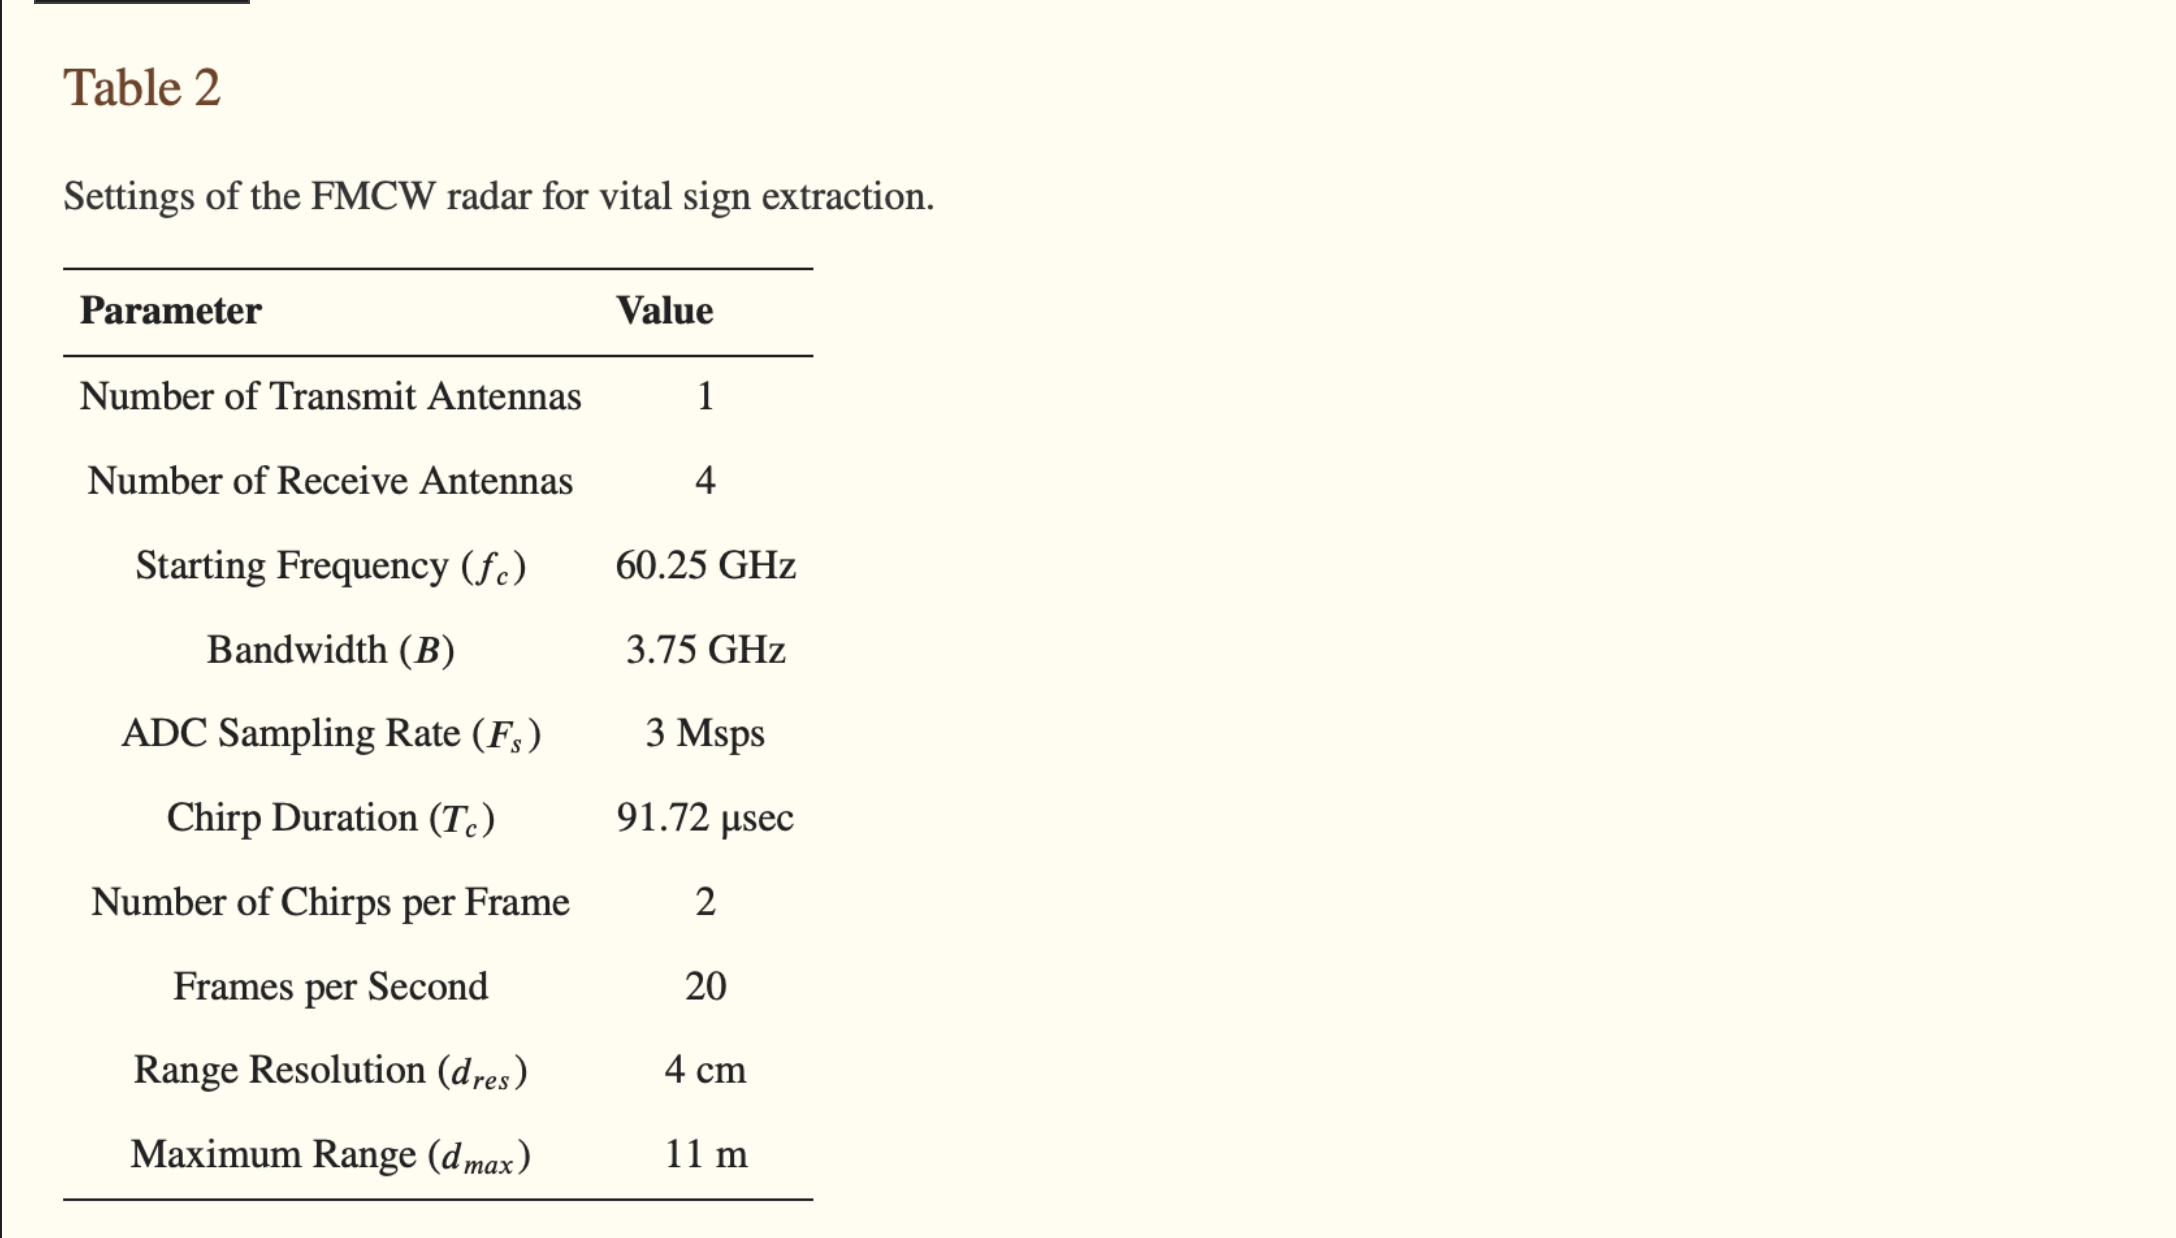

In [3]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [4]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


300
256


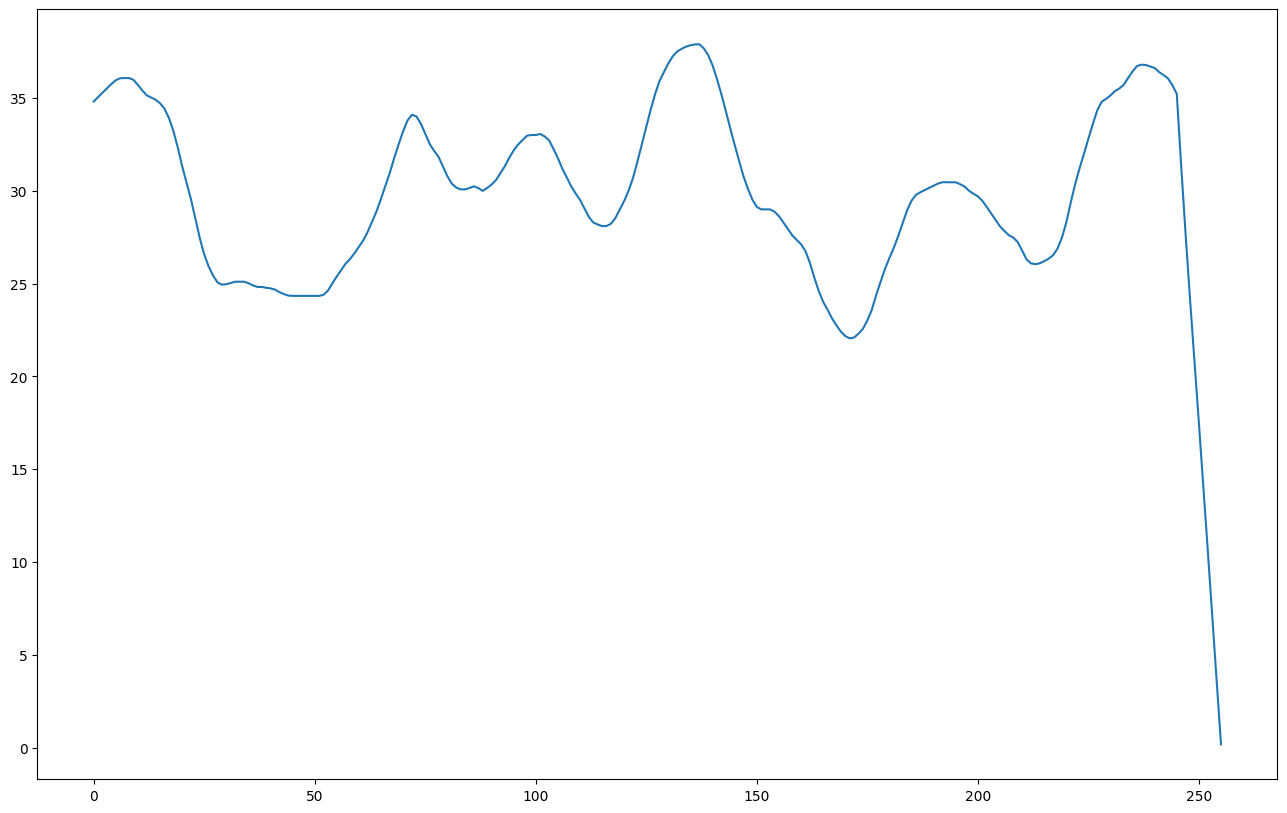

In [5]:
breaths=[]

with open('FMCW Radar/Heart Rate & Breathing Rate/Breath_1.csv', 'r') as file:
# Read the lines of the file
    lines = file.readlines()
    breaths = [float(breath) for breath in lines]

breas =[]
for breath in breaths:
    if(breath>0):
        breas.append(breath)
        
print(len(breaths))
print(len(breas))
plt.figure(figsize=(16, 10))
plt.plot(breas)
plt.show()

In [6]:

delayed_signal = np.zeros_like(first_chirps_of_frame)
mti_signal = np.zeros_like(first_chirps_of_frame)
for pulse_idx in range(len(first_chirps_of_frame)):    
    current_pulse = first_chirps_of_frame[pulse_idx]
    if pulse_idx>0:
        mti_signal[pulse_idx] = current_pulse -delayed_signal[pulse_idx-1]
    delayed_signal[pulse_idx]= current_pulse
print(len(mti_signal))
first_chirps_of_frame = mti_signal

6000


In [7]:
fft_chirps = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitude_spectrums = [np.abs(fft_chirp) for fft_chirp in fft_chirps]

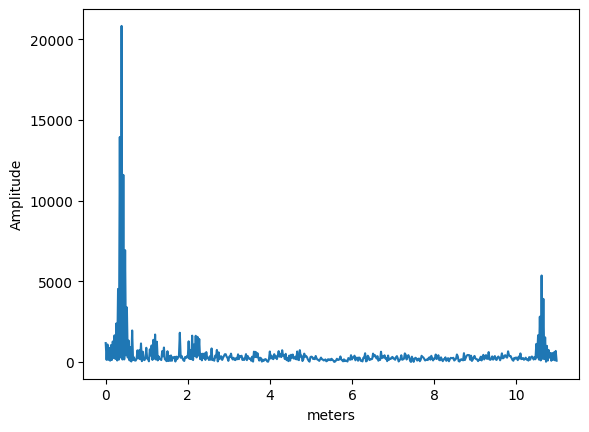

In [24]:
x= np.arange(0,11,11/len(magnitude_spectrums[0]))
# plt.plot(x,magnitude_spectrums[0])
plt.plot(x,magnitude_spectrums[1])
plt.xlabel('meters')
plt.ylabel('Amplitude')
plt.show()


In [9]:
#find it's manitude
magnitude_index = np.zeros(shape=len(magnitude_spectrums))
for  magnitude_spectrum in magnitude_spectrums:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[1:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]

for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",bin_of_interest)



index: 0  :  1.0
index: 11  :  7.0
index: 13  :  244.0
index: 15  :  674.0
index: 17  :  3161.0
index: 19  :  1159.0
index: 21  :  126.0
index: 23  :  30.0
index: 25  :  2.0
index: 27  :  1.0
index: 33  :  1.0
index: 49  :  1.0
index: 59  :  50.0
index: 61  :  50.0
index: 63  :  29.0
index: 65  :  25.0
index: 67  :  19.0
index: 69  :  34.0
index: 71  :  48.0
index: 73  :  56.0
index: 75  :  39.0
index: 77  :  46.0
index: 79  :  52.0
index: 81  :  20.0
index: 83  :  23.0
index: 85  :  10.0
index: 87  :  13.0
index: 89  :  5.0
index: 91  :  5.0
index: 93  :  8.0
index: 95  :  4.0
index: 97  :  8.0
index: 99  :  3.0
index: 101  :  3.0
index: 103  :  8.0
index: 105  :  5.0
index: 107  :  6.0
index: 109  :  10.0
index: 111  :  11.0
index: 113  :  1.0
index: 171  :  1.0
index: 195  :  1.0
bin of interest:  [17]


300.0


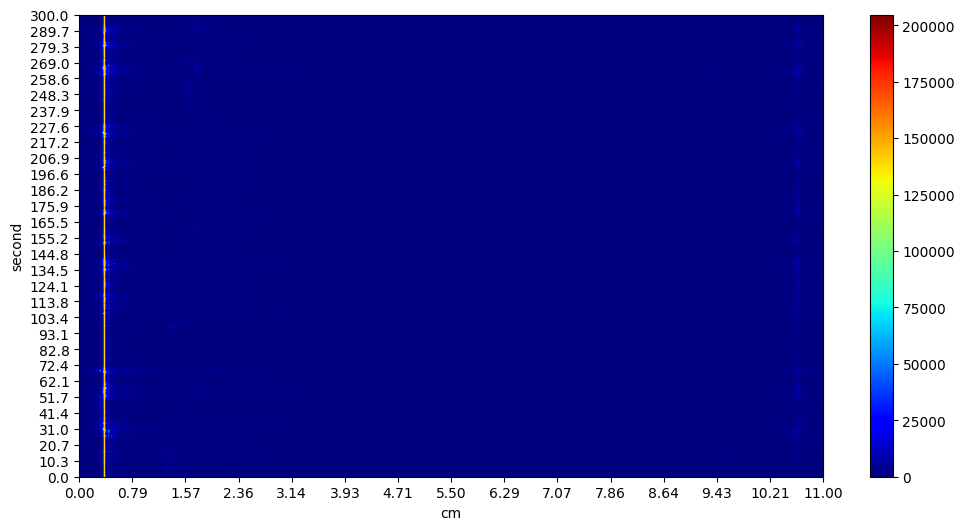

In [10]:
tmp_array= copy.deepcopy(magnitude_spectrums)
for _i,tmp in enumerate(tmp_array):
    
    tmp[bin_of_interest]=140000
    # tmp[bin_of_interest+1]=140000
    # tmp[bin_of_interest+2]=140000

   

plt.figure(figsize=(12, 6))
xmin=0
xmax=11
x = np.linspace(xmin, xmax, 15)
ymin=0
ymax=len(tmp_array)/20 #6000 chirp ~6000 frame each second has 20 frame -> second
#ymax ~300s ~5mins
print(ymax)
y = np.linspace(ymin, ymax, 30)
plt.xticks(x)
plt.yticks(y)

plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[xmin,xmax,ymin,ymax])
plt.xlabel('cm')
plt.ylabel('second')
plt.colorbar()
plt.show()


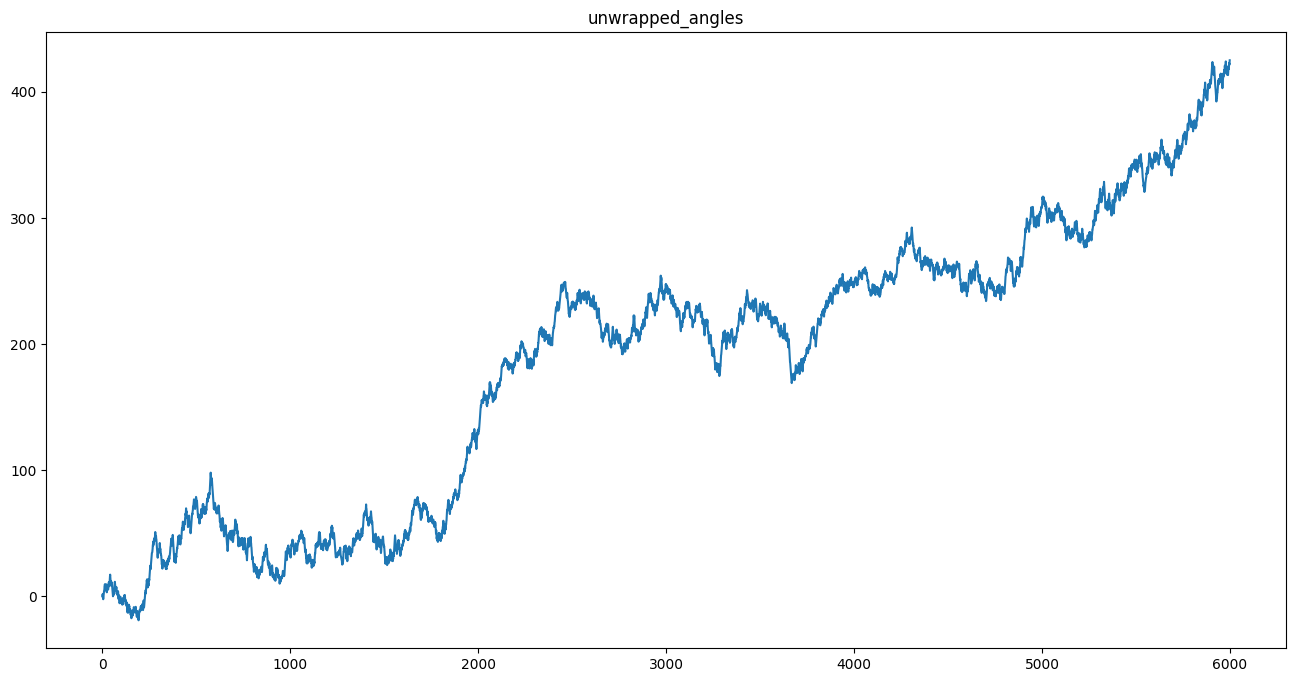

In [11]:
interested_ffts =[]
for _i,fft_chirp in enumerate(fft_chirps):
    interested_ffts.append(fft_chirp[bin_of_interest])
    
interested_angles = np.angle(np.array(interested_ffts).flatten())
unwrapped_angles=np.unwrap(interested_angles)
plt.figure(figsize=(16,8))
plt.plot(unwrapped_angles)
plt.title("unwrapped_angles")
plt.show()


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


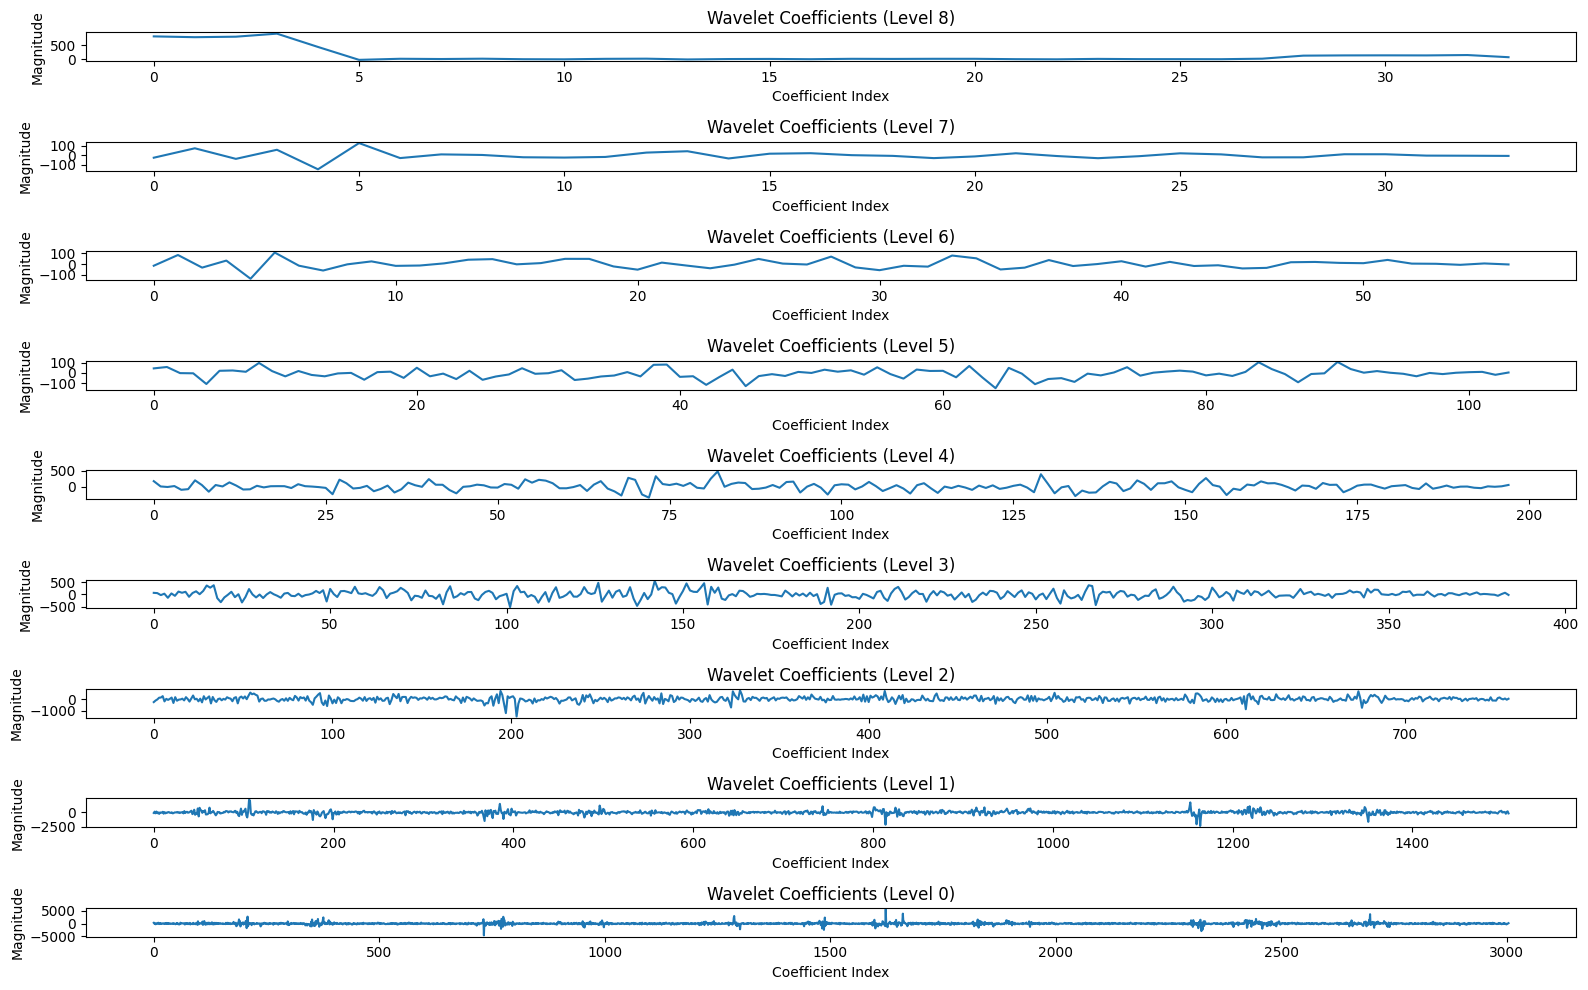

In [13]:

complex_ffts = np.array(interested_ffts).flatten()

wavelet = 'sym6'  
level = 8  # Number of decomposition levels

coeffs = pywt.wavedec(complex_ffts, wavelet, level=level)


# Plot the complex signal and its wavelet transform coefficients
plt.figure(figsize=(16, 10))

# # Plot the wavelet transform coefficients
for i in range(level+1):
    plt.subplot(level + 1, 1, i +1)
    plt.plot(coeffs[i])
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')
    plt.title(f'Wavelet Coefficients (Level {level-i})')
    
plt.tight_layout()
plt.show()


[ 60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199.]
[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


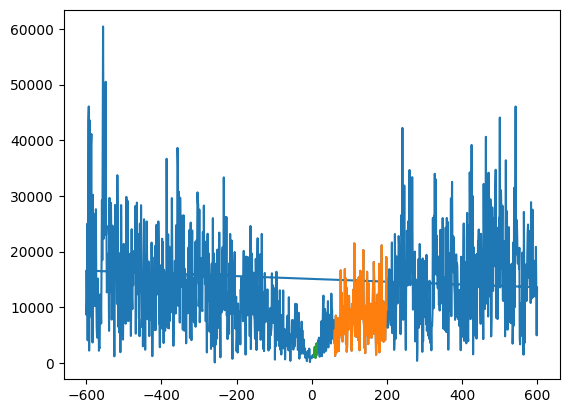

In [23]:
complex_ffts = np.array(interested_ffts).flatten()
one_minute_signal = complex_ffts[0:1200]
one_minute_fft = np.fft.fft(one_minute_signal)
frequencies = np.fft.fftfreq(len(one_minute_signal), d=1/(20*60))

plt.plot(frequencies,np.abs(one_minute_fft))

plt.plot(frequencies[60:200],np.abs(one_minute_fft[60:200]))
plt.plot(frequencies[5:15],np.abs(one_minute_fft[5:15]))
print(frequencies[60:200])
print(frequencies[5:15])

In [ ]:
interesting_index = 2
reconstructed_coefficients = [coeffs[interesting_index]] + [None] * level 
print(type(coeffs))
reconstructed_signal_ = pywt.waverec(reconstructed_coefficients, wavelet)
fft_reconstructed = np.fft.fft(reconstructed_signal_[:1200])
print(fft_reconstructed[5:17])
plt.figure(figsize=(16, 10))
plt.subplot(3 , 1,  1)
plt.plot(reconstructed_signal_)

plt.subplot(3 , 1,  2)
plt.plot(fft_reconstructed)


plt.subplot(3 , 1,  3)
plt.plot(coeffs[interesting_index])

plt.tight_layout()
plt.show()

